In [1]:
import sys

import numpy as np
from scipy.stats import norm

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.stats import chi2, norm

sys.path.append('..')
from higgs_inference import settings
from higgs_inference.various.utils import format_number, weighted_quantile

# Strategies and data

In [27]:
folders = ['parameterized'] * 4
filenames = ['carl_shallow',
             'regression',
             'combined_deep',
             'combinedregression_deep']
filenames_cal = ['carl_calibrated_shallow',
             'regression_calibrated',
             'combined_calibrated_deep',
             'combinedregression_calibrated_deep']


In [8]:
y_train = np.load('../data/unweighted_events/y_train.npy')
rhats = []

for filename, folder in zip(filenames, folders):
    rhats.append(np.load('../results/' + folder + '/r_train_' + filename + '.npy'))
    

# Calculate variance

In [ ]:
# Find events for thetas, generated according to theta1
indices_theta1 = [ [] for t in range(settings.n_thetas)]
indices_theta0 = [ [] for t in range(settings.n_thetas)]
t = 17
last = 0
for i, y in enumerate(y_train):
    if y == 1:
        indices_theta1[t].append(i)
        last = 1
    elif y == 0:
        if last == 1: # Done with a theta
            t += 1
        indices_theta0[t].append(i)
        last = 0
    else:
        print(y)

In [23]:
q_errors = []
q_errors_large = []

for rhat in rhats:
    
    expected_r = np.zeros(settings.n_thetas)
    expected_r_std = np.zeros(settings.n_thetas)
    expected_r_std_large = np.zeros(settings.n_thetas)
    q_error = np.zeros(settings.n_thetas)
    q_error_large = np.zeros(settings.n_thetas)
    
    for t in range(settings.n_thetas):
        if len(indices_theta1[t]) > 0:
            expected_r[t] = np.mean(rhat[indices_theta1[t]])
            expected_r_std[t] = (1. / 50000. * max((np.mean(rhat[indices_theta0[t]]) - 1.),0.))**0.5
            expected_r_std_large[t] = (1. / 1.e7 * max((np.mean(rhat[indices_theta0[t]]) - 1.),0.))**0.5
            q_error[t] = 2. * 36. * expected_r_std[t] / expected_r[t]
            q_error_large[t] = 2. * 36. * expected_r_std_large[t] / expected_r[t]
        else:
            expected_r[t] = np.nan
            expected_r_std[t] = np.nan
            q_error[t] = np.nan
            q_error_large[t] = np.nan
    
    q_errors.append(q_error)
    q_errors_large.append(q_error_large)
            

In [28]:

for filename, filename_cal, folder, q_error, q_error_large in zip(filenames, filenames_cal, folders, q_errors, q_errors_large):
    
    np.save('../results/' + folder + '/recalibration_uncertainty_' + filename + '.npy', q_error)
    np.save('../results/' + folder + '/recalibration_uncertainty_' + filename_cal + '.npy', q_error)
    

[       nan        nan        nan ... 0.01337281 0.         0.0117254 ]
[       nan        nan        nan ... 0.04163121 0.02170683 0.02622095]
[nan nan nan ...  0.  0.  0.]
[       nan        nan        nan ... 0.03117846 0.01719796 0.01822433]


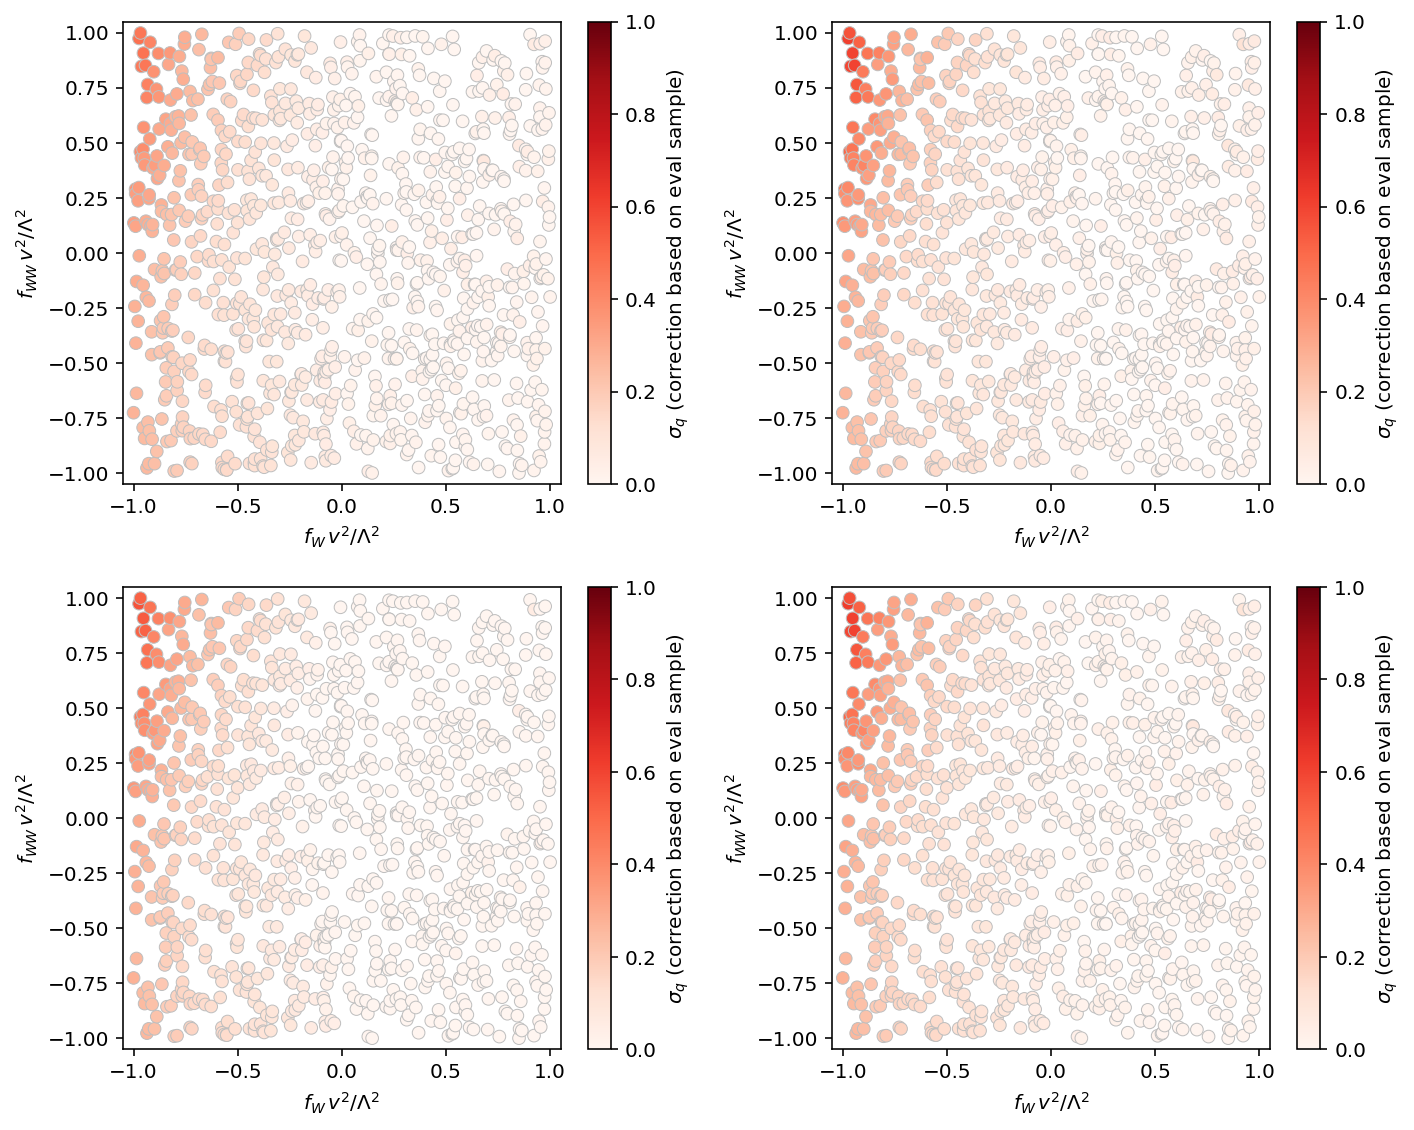

In [29]:
plt.figure(figsize=(10,8))

for i, q_error in enumerate(q_errors):
    print(q_error)
    
    plt.subplot(2,2,i+1)
    plt.scatter(settings.thetas[:,0], settings.thetas[:,1], c=q_error,
                s=40.,
                edgecolor='0.75', lw=0.5,
                cmap='Reds',
                vmin=0., vmax=1.)

    cbar = plt.colorbar()

    plt.xlim(-1.05,1.05)
    plt.ylim(-1.05,1.05)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$\sigma_q$ (correction based on eval sample)')
    
plt.tight_layout()

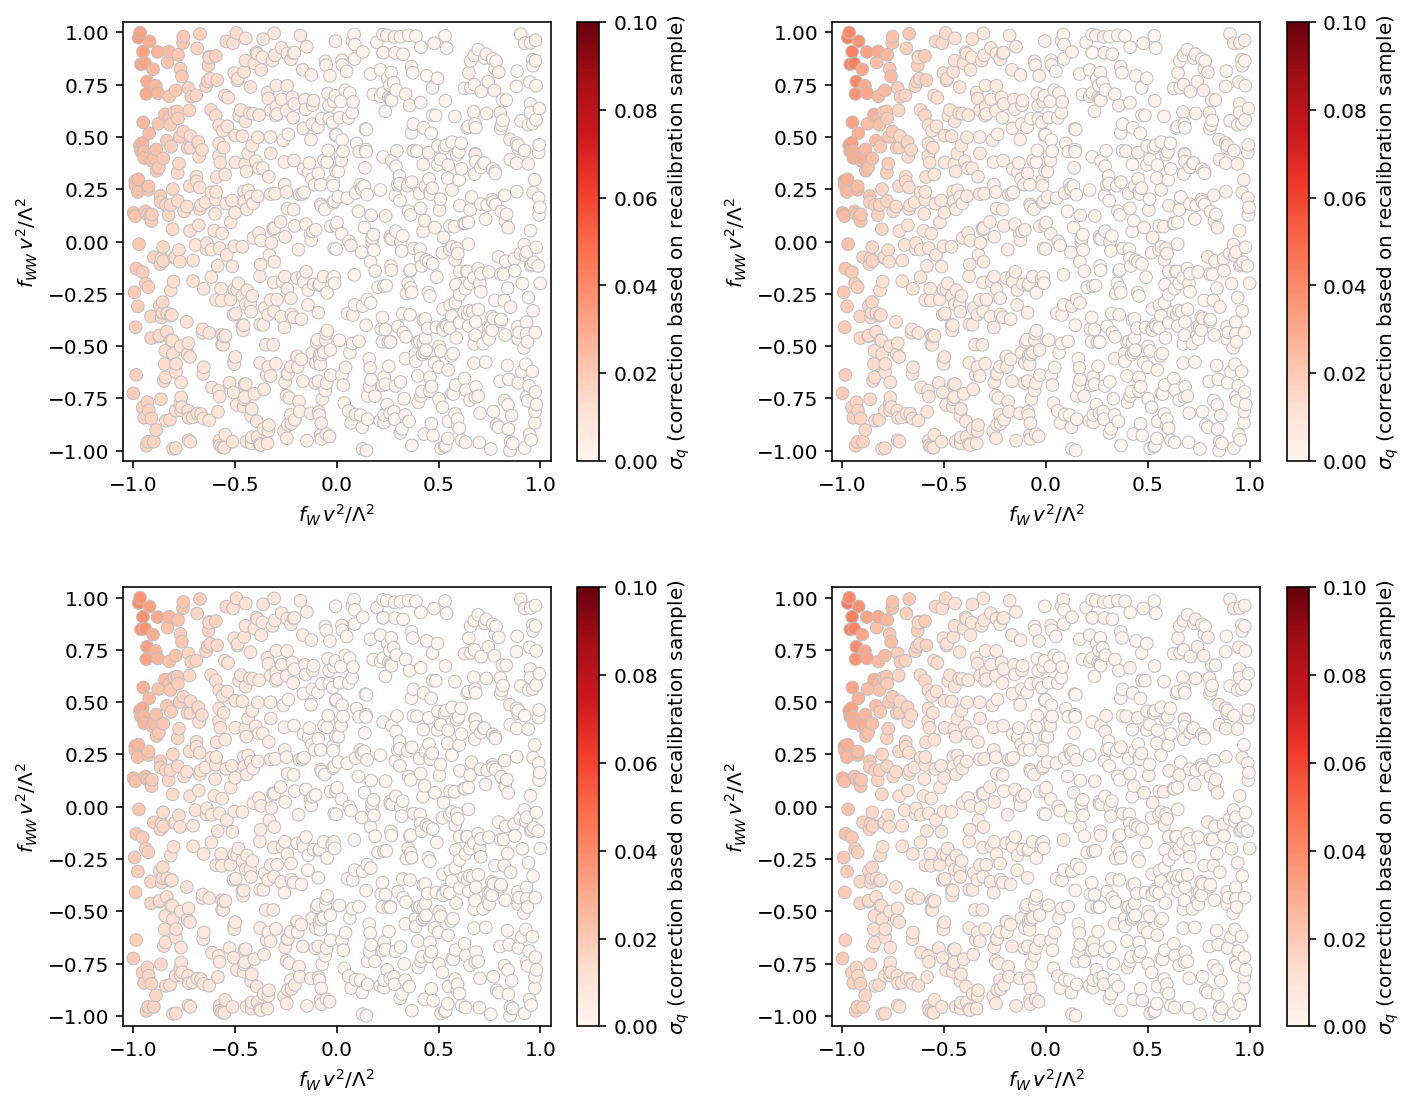

In [26]:
plt.figure(figsize=(10,8))

for i, q_error_large in enumerate(q_errors_large):

    plt.subplot(2,2,i+1)
    plt.scatter(settings.thetas[:,0], settings.thetas[:,1], c=q_error_large,
                s=40.,
                edgecolor='0.75', lw=0.5,
                cmap='Reds',
                vmin=0., vmax=.1)

    cbar = plt.colorbar()

    plt.xlim(-1.05,1.05)
    plt.ylim(-1.05,1.05)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$\sigma_q$ (correction based on recalibration sample)')
    
plt.tight_layout()